In [1]:
import sqlite3
import pandas as pd
import filler
import trainer

# Check data quality

In [2]:
def identify_data_issues(df):
    """
    Identify duplicated timestamps, missing intervals, and 
    out-of-order rows in a time-indexed DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing a 'Time' column.
        
    Returns:
        duplicates (pd.DataFrame): Rows that contain duplicate timestamps.
        missing_intervals (pd.DatetimeIndex): Start points of intervals where data is missing.
        is_unordered (bool): True if the data is not strictly time-ordered.
    """
    # Ensure 'Time' is a datetime column
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    
    # Check for any NaT (Not a Time) conversions which indicate invalid timestamps
    if df['Time'].isnull().any():
        raise ValueError("Some timestamps could not be converted to datetime.")
    
    # Check if the data is ordered by 'Time'. If not, sort it.
    if not df['Time'].is_monotonic_increasing:
        is_unordered = True
        df = df.sort_values('Time').reset_index(drop=True)
    else:
        is_unordered = False
    
    # Identify duplicates
    duplicates = df[df.duplicated(subset='Time', keep=False)]

    # Identify missing intervals
    # Calculate the difference between consecutive rows
    time_diffs = df['Time'].diff().dropna()
    # Any gap larger than 1 minute indicates missing intervals
    missing_intervals = time_diffs[time_diffs > pd.Timedelta('1min')]

    return duplicates, missing_intervals, is_unordered

# Example usage:
df = filler.read_data_from_table("ethusd")  # Assuming you have a function that reads from SQLite
duplicates, missing_intervals, is_unordered = identify_data_issues(df)
print("Duplicates:\n", duplicates)
print("Missing intervals:\n", missing_intervals)
print("Data is unordered:", is_unordered)


Duplicates:
 Empty DataFrame
Columns: [Time, Open, High, Low, Close, Volume]
Index: []
Missing intervals:
 Series([], Name: Time, dtype: timedelta64[ns])
Data is unordered: False


# See database

In [10]:
# Define database connection function
def connect_to_sqlite():
    conn = sqlite3.connect("crypto_data.sqlite", check_same_thread=False)
    conn.execute("PRAGMA journal_mode=WAL;")  # Enable concurrent reads and writes
    return conn

def load_preds():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM predictions 
        WHERE timestamp > '2024-12-18 18:55:00'
        ORDER BY timestamp DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('timestamp')

preds = load_preds()
# Remove duplicate rows from the DataFrame
preds = preds.drop_duplicates()
preds

,timestamp,current_close_price,predicted_next_absolute_max,predicted_percentage_change
228,2024-12-18 18:57:00,3885.29,3883.696533,-0.041013
227,2024-12-18 18:58:00,3890.19,3885.306152,-0.125543
225,2024-12-18 18:59:00,3894.80,3886.915283,-0.202442
226,2024-12-18 18:59:00,3894.80,3891.026367,-0.096889
224,2024-12-18 19:00:00,3891.81,3888.786133,-0.077698
...,...,...,...,...
4,2024-12-18 22:50:00,3683.25,3696.186523,0.351226
3,2024-12-18 22:51:00,3686.81,3683.607910,-0.086853
2,2024-12-18 22:52:00,3685.41,3683.557861,-0.050256
1,2024-12-18 22:53:00,3685.42,3686.610840,0.032312


In [11]:

def load_data():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM ethusd 
        WHERE Time > '2024-12-18 16:55:00'
        ORDER BY Time DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('Time')

data = load_data()
# Remove duplicate rows from the DataFrame
data = data.drop_duplicates()

data

,Time,Open,High,Low,Close,Volume
359,2024-12-18 16:56:00,3876.25,3876.26,3873.70,3873.70,74.4401
358,2024-12-18 16:57:00,3873.70,3874.60,3871.27,3871.27,111.4281
357,2024-12-18 16:58:00,3871.27,3873.00,3870.07,3872.79,121.8399
356,2024-12-18 16:59:00,3872.79,3873.70,3872.18,3872.19,176.8223
355,2024-12-18 17:00:00,3872.19,3872.19,3870.67,3870.81,175.8266
...,...,...,...,...,...,...
4,2024-12-18 22:51:00,3686.75,3686.82,3686.74,3686.81,66.0749
3,2024-12-18 22:52:00,3685.42,3685.42,3685.41,3685.41,63.3102
2,2024-12-18 22:53:00,3685.41,3685.42,3685.41,3685.42,66.8711
1,2024-12-18 22:54:00,3685.42,3688.22,3685.41,3687.97,58.6208


In [12]:
# Convert to datetime if not already
preds['timestamp'] = pd.to_datetime(preds['timestamp'])
data['Time'] = pd.to_datetime(data['Time'])

# Create a new column in preds for the join key: timestamp minus 60 minutes
preds['timestamp_minus_60'] = preds['timestamp'] - pd.Timedelta(minutes=60)

# Perform a left merge, matching preds.timestamp_minus_60 to data.Time
merged_df = preds.merge(
    data[['Time', 'Close']],            # Select only the columns we need from data
    how='left',
    left_on='timestamp_minus_60',
    right_on='Time'
)

# The merged_df now contains all rows from preds along with the matching 'Close' from data 
# where data.Time = preds.timestamp - 60 minutes.

# You can drop the 'Time' column (from data) and the helper column if you like:
merged_df = merged_df.drop(columns=['Time', 'timestamp_minus_60'])

merged_df


,timestamp,current_close_price,predicted_next_absolute_max,predicted_percentage_change,Close
0,2024-12-18 18:57:00,3885.29,3883.696533,-0.041013,3878.72
1,2024-12-18 18:58:00,3890.19,3885.306152,-0.125543,3878.59
2,2024-12-18 18:59:00,3894.80,3886.915283,-0.202442,3878.58
3,2024-12-18 18:59:00,3894.80,3891.026367,-0.096889,3878.58
4,2024-12-18 19:00:00,3891.81,3888.786133,-0.077698,3874.43
...,...,...,...,...,...
209,2024-12-18 22:50:00,3683.25,3696.186523,0.351226,3687.50
210,2024-12-18 22:51:00,3686.81,3683.607910,-0.086853,3691.91
211,2024-12-18 22:52:00,3685.41,3683.557861,-0.050256,3691.39
212,2024-12-18 22:53:00,3685.42,3686.610840,0.032312,3692.59


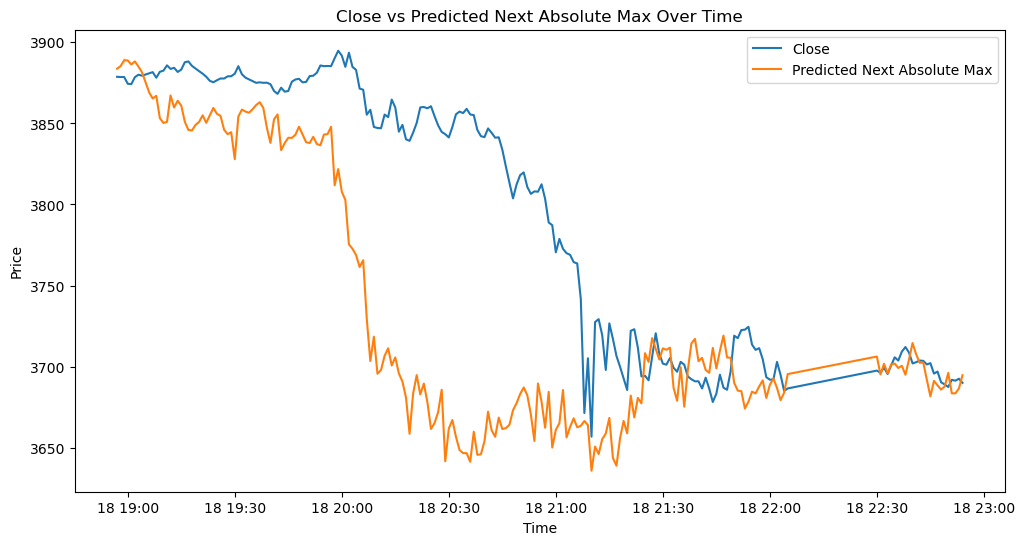

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that timestamp is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='timestamp', y='Close', label='Close')
sns.lineplot(data=merged_df, x='timestamp', y='predicted_next_absolute_max', label='Predicted Next Absolute Max')

plt.title("Close vs Predicted Next Absolute Max Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


# Run trainer

In [2]:
from trainer import train_model

# Custom hyperparameters
custom_hyperparameters = {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_child_weight": 5,
    "colsample_bytree": 0.5,
    "tree_method": 'hist',
}

train_model(hyperparameters=custom_hyperparameters)

Starting model training...
Model training completed and model saved.
